# Zackary Ducreux 
#### P2023
  
# Predictive modeling and unsupervised clustering
## Supervised Learning Project
###  

### Analyse of what is the dataset and first look at the data (images and labels)

Tissue Types 	 Sample Count
________________________________
TUMOR
class 1: TUMOR	 625
________________________________
STROMA
class 2: STROMA	 625
________________________________
COMPLEX
class 3: COMPLEX	 625
________________________________
LYMPHO
class 4: LYMPHO	 625
________________________________
DEBRIS
class 5: DEBRIS	 625
________________________________
MUCOSA
class 6: MUCOSA	 625
________________________________
ADIPOSE
class 7: ADIPOSE	 625
________________________________
EMPTY
class 8: EMPTY	 625
________________________________


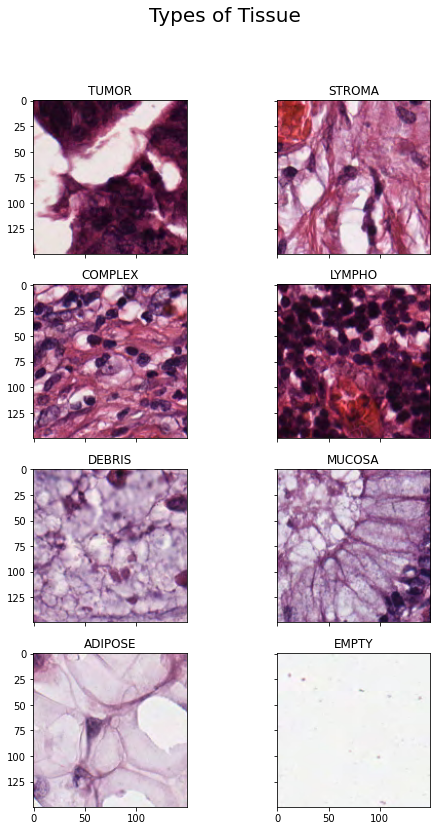

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

directory = 'Kather_texture_2016_image_tiles_5000'
tissue_im_p = {} # keys: tissue type # Val: Filenames of images

i = 0
for root_dir, dirnames, filenames in os.walk(directory):
    if i == 0:
        print('Tissue Types \t Sample Count')
        
    else:
        tissue_im_p[root_dir.split('/')[-1][3:]] = [os.path.join(root_dir, filenames[k]) for k in range(len(filenames))]
        name = root_dir.split('/')[-1][3:].split("_")[-1]
        print(name)
        print(f"class {i}: {name}\t", len(filenames))
    i += 1
    print('________________________________')
    
# Lets look at an image from each type
rows = 4
cols = 2
fig, axs = plt.subplots(rows, cols, sharex=True, sharey=True, figsize=(8, 13))
fig.suptitle('Types of Tissue', fontsize = 20.0)

for j, tissue in enumerate(tissue_im_p):
    ax = axs[j//cols][j%cols]
    ax.set_title(tissue.split("_")[-1])
    img = np.asarray(Image.open(tissue_im_p[tissue][np.random.randint(0,len(tissue_im_p[tissue]))]))
    ax.imshow(img)

##### As we can see there is 8 different labels composed of 625 pictures each.

##### Imports of the model

In [2]:
from os import listdir
from os.path import isfile, join, isdir
from PIL import Image
import pandas as pd
from numpy import asarray
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
import tensorflow as tf
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from os import listdir
from os.path import isfile, join, isdir
from sklearn.model_selection import GridSearchCV
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(3)
import logging
tf.get_logger().setLevel(logging.ERROR)

##### Import the images and transform in a DataFrame

In [3]:
mypath = 'Kather_texture_2016_image_tiles_5000'
onlyfolder = [f for f in listdir(mypath) if isdir(join(mypath, f))]
onlyfolder

['01_TUMOR',
 '02_STROMA',
 '03_COMPLEX',
 '04_LYMPHO',
 '05_DEBRIS',
 '06_MUCOSA',
 '07_ADIPOSE',
 '08_EMPTY']

In [4]:
df_images_labels = pd.DataFrame(columns=['image', 'label'])
current_index = 0
for folder in onlyfolder:
    onlyfiles = [f for f in listdir(f'{mypath}/{folder}') if isfile(join(f'{mypath}/{folder}', f))]
    for file in onlyfiles:  
        img = Image.open(f'{mypath}/{folder}/{file}')
        numpydata = asarray(img).astype('float32')
        new_row = {'image': numpydata, 'label': folder.split("_")[1]}
        new_df = pd.DataFrame([new_row], columns=df_images_labels.columns, index=[current_index])
        df_images_labels = pd.concat([df_images_labels, new_df])
        current_index += 1

##### Shapes and X, Y

In [5]:
img_size = numpydata.shape[0]
numpydata.shape

(150, 150, 3)

In [6]:
df_images_labels.shape

(5000, 2)

In [7]:
X = df_images_labels['image']
y = df_images_labels['label']

In [8]:
X = np.array(list(X.values), dtype=float)

In [9]:
class_names = df_images_labels['label'].unique()
class_names

array(['TUMOR', 'STROMA', 'COMPLEX', 'LYMPHO', 'DEBRIS', 'MUCOSA',
       'ADIPOSE', 'EMPTY'], dtype=object)

## Preprossesing

### Describe and justify any data pre-processing you had to do

First we have to split train and test with the tenserflow function. Then we need to apply a label encode on the labels of the 'y_train' and 'y_test' variable so that the string they represented will be transformed into a number associated with their label.

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
lb = LabelEncoder()
y_lb = lb.fit_transform(y_train)
y_lb_test = lb.fit_transform(y_test)

#### Verify the size of test and train dataframes

In [12]:
X_train.shape, y_lb.shape

((4000, 150, 150, 3), (4000,))

In [13]:
X_test.shape, y_lb_test.shape

((1000, 150, 150, 3), (1000,))

## Logs

In [14]:
LOG_DIR = 'logs'

def best_model_path(model_name):
    base_dir  = os.path.join(LOG_DIR, model_name)
    return os.path.join(base_dir, 'best_val_accuracy.ckpt')

def callback_list(model_name):
    base_dir  = os.path.join(LOG_DIR, model_name)
    tb_cb = tf.keras.callbacks.TensorBoard(base_dir)
    ckpt = tf.keras.callbacks.ModelCheckpoint(
         best_model_path(model_name),
         monitor='val_accuracy',
         mode='max', 
         verbose=0,
         save_best_only=True)
    backup_dir = os.path.join(base_dir, 'backup_checkpoint')
    bkp = tf.keras.callbacks.BackupAndRestore(
        backup_dir)
    return [tb_cb, ckpt, bkp]


earlystop = tf.keras.callbacks.EarlyStopping('val_loss', patience=20, restore_best_weights=True)

#### Plot accuracy and loss function 

In [15]:
def plot_learning_curves(history):
    df = pd.DataFrame(history.history, index=np.array(history.epoch)+1)
    df.plot(figsize=(8, 5), fontsize=12)
    plt.grid(True)
    plt.gca().set_ylim(0, 1.2)
    plt.gca().set_xlim(0, 20)
    plt.xlabel('epochs', fontsize=12)
    plt.title ('learning curves', fontsize=12)
    plt.legend(fontsize=12)
    plt.show()

#### Parameters

In [16]:
num_classes = len(class_names)
EPOCHS = 20
input_shape = X_train[0].shape
input_shape, num_classes

((150, 150, 3), 8)

## Models

# Sequential baseline model:

In [17]:
SEED = 123
tf.keras.utils.set_random_seed(SEED)

model_1 = Sequential([
    layers.Rescaling(1./255, input_shape=input_shape),
    layers.Conv2D(16, 3, activation='relu', padding="same"),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='sigmoid')])

In [18]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 16)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 90000)             0         
                                                                 
 dense (Dense)               (None, 128)               11520128  
                                                                 
 dense_1 (Dense)             (None, 8)                 1032      
                                                        

In [19]:
model_1.compile(optimizer='adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [20]:
logs = {}
MODEL_NAME = 'baseline_model'

logs[MODEL_NAME] = model_1.fit(X_train, y_lb, validation_data=(X_test, y_lb_test), 
                             epochs=EPOCHS, callbacks=[callback_list(MODEL_NAME), earlystop])

Epoch 1/20


C:\Users\zducreux\Anaconda3\lib\site-packages\keras\backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


125/125 [==============================] - ETA: 0s - loss: 2.4930 - accuracy: 0.4425

125/125 [==============================] - 28s 206ms/step - loss: 2.4930 - accuracy: 0.4425 - val_loss: 0.9030 - val_accuracy: 0.6970
Epoch 2/20
125/125 [==============================] - 23s 184ms/step - loss: 0.7973 - accuracy: 0.6693 - val_loss: 0.8418 - val_accuracy: 0.5970
Epoch 3/20
125/125 [==============================] - 22s 178ms/step - loss: 0.6399 - accuracy: 0.7545 - val_loss: 0.8435 - val_accuracy: 0.6510
Epoch 4/20
125/125 [==============================] - ETA: 0s - loss: 0.5584 - accuracy: 0.7837

125/125 [==============================] - 21s 168ms/step - loss: 0.5584 - accuracy: 0.7837 - val_loss: 0.8235 - val_accuracy: 0.7110
Epoch 5/20
125/125 [==============================] - ETA: 0s - loss: 0.3989 - accuracy: 0.8687

125/125 [==============================] - 24s 190ms/step - loss: 0.3989 - accuracy: 0.8687 - val_loss: 0.7216 - val_accuracy: 0.7200
Epoch 6/20
125/125 [==============================] - 21s 169ms/step - loss: 0.3718 - accuracy: 0.8737 - val_loss: 0.8088 - val_accuracy: 0.6750
Epoch 7/20
125/125 [==============================] - 20s 159ms/step - loss: 0.2917 - accuracy: 0.9087 - val_loss: 0.8306 - val_accuracy: 0.6710
Epoch 8/20
125/125 [==============================] - ETA: 0s - loss: 0.2009 - accuracy: 0.9460

125/125 [==============================] - 23s 183ms/step - loss: 0.2009 - accuracy: 0.9460 - val_loss: 0.8310 - val_accuracy: 0.7270
Epoch 9/20
125/125 [==============================] - 20s 162ms/step - loss: 0.1415 - accuracy: 0.9655 - val_loss: 0.8240 - val_accuracy: 0.7230
Epoch 10/20
125/125 [==============================] - 20s 160ms/step - loss: 0.1370 - accuracy: 0.9668 - val_loss: 0.8254 - val_accuracy: 0.7190
Epoch 11/20
125/125 [==============================] - 20s 164ms/step - loss: 0.0837 - accuracy: 0.9822 - val_loss: 0.9367 - val_accuracy: 0.6260
Epoch 12/20
125/125 [==============================] - ETA: 0s - loss: 0.0947 - accuracy: 0.9740

125/125 [==============================] - 21s 168ms/step - loss: 0.0947 - accuracy: 0.9740 - val_loss: 0.8242 - val_accuracy: 0.7350
Epoch 13/20
125/125 [==============================] - 23s 188ms/step - loss: 0.0774 - accuracy: 0.9787 - val_loss: 1.0645 - val_accuracy: 0.6550
Epoch 14/20
125/125 [==============================] - 23s 185ms/step - loss: 0.1769 - accuracy: 0.9420 - val_loss: 1.0566 - val_accuracy: 0.6640
Epoch 15/20
125/125 [==============================] - 21s 172ms/step - loss: 0.1241 - accuracy: 0.9647 - val_loss: 0.9271 - val_accuracy: 0.6970
Epoch 16/20
125/125 [==============================] - 21s 165ms/step - loss: 0.0772 - accuracy: 0.9778 - val_loss: 1.0148 - val_accuracy: 0.7060
Epoch 17/20
125/125 [==============================] - 22s 178ms/step - loss: 0.1004 - accuracy: 0.9732 - val_loss: 1.2453 - val_accuracy: 0.6420
Epoch 18/20
125/125 [==============================] - 21s 165ms/step - loss: 0.0793 - accuracy: 0.9800 - val_loss: 0.9983 - val_accurac

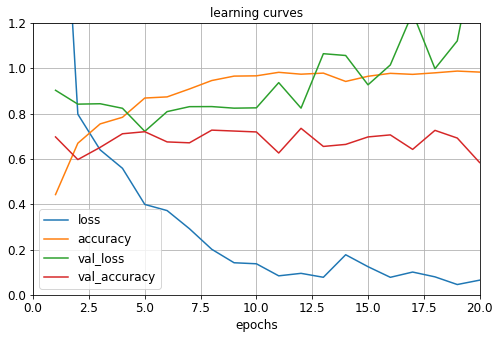

In [21]:
plot_learning_curves(logs['baseline_model'])

### This model is overfitting as we can see with the Val_loss that is incresing instead of following the curve of the loss of the training.

# Sequential developped model:

In [22]:
SEED = 123
tf.keras.utils.set_random_seed(SEED)

model_2 = Sequential([
    layers.Rescaling(1./255, input_shape=input_shape),
    layers.Conv2D(64, 3, activation='relu', padding="same"),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu', padding="same"),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu', padding="same"),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu', padding="same"),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu', padding="same"),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='sigmoid')])

In [23]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 64)      1792      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 75, 75, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 37, 37, 128)      

In [24]:
model_2.compile(optimizer='adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [25]:
logs = {}
MODEL_NAME = 'developed_model'

logs[MODEL_NAME] = model_2.fit(X_train, y_lb, validation_data=(X_test, y_lb_test), 
                             epochs=EPOCHS, callbacks=[callback_list(MODEL_NAME), earlystop])

Epoch 1/20


C:\Users\zducreux\Anaconda3\lib\site-packages\keras\backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


125/125 [==============================] - ETA: 0s - loss: 1.4570 - accuracy: 0.3515

125/125 [==============================] - 124s 985ms/step - loss: 1.4570 - accuracy: 0.3515 - val_loss: 1.0154 - val_accuracy: 0.5490
Epoch 2/20
125/125 [==============================] - ETA: 0s - loss: 0.9571 - accuracy: 0.5630

125/125 [==============================] - 119s 953ms/step - loss: 0.9571 - accuracy: 0.5630 - val_loss: 0.8169 - val_accuracy: 0.6980
Epoch 3/20
125/125 [==============================] - ETA: 0s - loss: 0.8005 - accuracy: 0.6658

125/125 [==============================] - 115s 917ms/step - loss: 0.8005 - accuracy: 0.6658 - val_loss: 0.7004 - val_accuracy: 0.7310
Epoch 4/20
125/125 [==============================] - ETA: 0s - loss: 0.7621 - accuracy: 0.6970

125/125 [==============================] - 114s 914ms/step - loss: 0.7621 - accuracy: 0.6970 - val_loss: 0.6522 - val_accuracy: 0.7500
Epoch 5/20
125/125 [==============================] - 111s 886ms/step - loss: 0.7062 - accuracy: 0.7255 - val_loss: 0.8354 - val_accuracy: 0.6500
Epoch 6/20
125/125 [==============================] - 107s 856ms/step - loss: 0.6121 - accuracy: 0.7588 - val_loss: 0.6938 - val_accuracy: 0.7270
Epoch 7/20
125/125 [==============================] - ETA: 0s - loss: 0.5463 - accuracy: 0.7940

125/125 [==============================] - 117s 939ms/step - loss: 0.5463 - accuracy: 0.7940 - val_loss: 0.5589 - val_accuracy: 0.7960
Epoch 8/20
125/125 [==============================] - 107s 857ms/step - loss: 0.4812 - accuracy: 0.8210 - val_loss: 0.6291 - val_accuracy: 0.7750
Epoch 9/20
125/125 [==============================] - ETA: 0s - loss: 0.4790 - accuracy: 0.8250

125/125 [==============================] - 117s 937ms/step - loss: 0.4790 - accuracy: 0.8250 - val_loss: 0.4588 - val_accuracy: 0.8300
Epoch 10/20
125/125 [==============================] - 121s 968ms/step - loss: 0.4304 - accuracy: 0.8275 - val_loss: 0.5253 - val_accuracy: 0.8070
Epoch 11/20
125/125 [==============================] - 124s 996ms/step - loss: 0.3790 - accuracy: 0.8510 - val_loss: 0.4862 - val_accuracy: 0.8230
Epoch 12/20
125/125 [==============================] - ETA: 0s - loss: 0.3808 - accuracy: 0.8485

125/125 [==============================] - 135s 1s/step - loss: 0.3808 - accuracy: 0.8485 - val_loss: 0.4562 - val_accuracy: 0.8320
Epoch 13/20
125/125 [==============================] - 124s 990ms/step - loss: 0.3467 - accuracy: 0.8692 - val_loss: 0.5120 - val_accuracy: 0.8290
Epoch 14/20
125/125 [==============================] - 121s 967ms/step - loss: 0.3241 - accuracy: 0.8823 - val_loss: 0.5562 - val_accuracy: 0.8150
Epoch 15/20
125/125 [==============================] - 132s 1s/step - loss: 0.2555 - accuracy: 0.9038 - val_loss: 0.5835 - val_accuracy: 0.8170
Epoch 16/20
125/125 [==============================] - 120s 958ms/step - loss: 0.2829 - accuracy: 0.8890 - val_loss: 0.6449 - val_accuracy: 0.8080
Epoch 17/20
125/125 [==============================] - 131s 1s/step - loss: 0.2216 - accuracy: 0.9175 - val_loss: 0.5467 - val_accuracy: 0.8250
Epoch 18/20
125/125 [==============================] - 131s 1s/step - loss: 0.1722 - accuracy: 0.9385 - val_loss: 0.6279 - val_accuracy: 0.

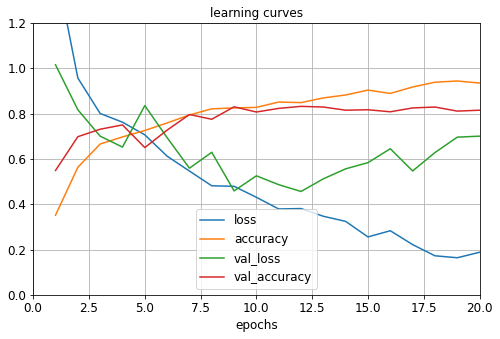

In [26]:
plot_learning_curves(logs['developed_model'])

# Sequential developped optimized  model:

#### Data augmentation (flip, zoom, rotation)

In [27]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip(mode="horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1, 0.1),
  ]
)

In [28]:
SEED = 123
tf.keras.utils.set_random_seed(SEED)

model_3 = Sequential([
    layers.Rescaling(1./255, input_shape=input_shape),
    data_augmentation,
    layers.Conv2D(64, 3, activation='relu', padding="same"),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu', padding="same"),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu', padding="same"),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu', padding="same"),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu', padding="same"),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='sigmoid')])

In [29]:
model_3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 sequential_2 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 150, 150, 64)      1792      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 75, 75, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 75, 75, 64)        36928     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                  

In [30]:
model_3.compile(optimizer='adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [31]:
logs = {}
MODEL_NAME = 'developed_optimized_model'

logs[MODEL_NAME] = model_3.fit(X_train, y_lb, validation_data=(X_test, y_lb_test), 
                             epochs=EPOCHS, callbacks=[callback_list(MODEL_NAME), earlystop])

Epoch 1/20


C:\Users\zducreux\Anaconda3\lib\site-packages\keras\backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


125/125 [==============================] - ETA: 0s - loss: 1.4993 - accuracy: 0.3400

125/125 [==============================] - 170s 1s/step - loss: 1.4993 - accuracy: 0.3400 - val_loss: 1.1002 - val_accuracy: 0.5030
Epoch 2/20
125/125 [==============================] - ETA: 0s - loss: 1.0182 - accuracy: 0.5320

125/125 [==============================] - 144s 1s/step - loss: 1.0182 - accuracy: 0.5320 - val_loss: 0.9137 - val_accuracy: 0.5920
Epoch 3/20
125/125 [==============================] - ETA: 0s - loss: 0.8837 - accuracy: 0.6170

125/125 [==============================] - 141s 1s/step - loss: 0.8837 - accuracy: 0.6170 - val_loss: 0.8844 - val_accuracy: 0.6260
Epoch 4/20
125/125 [==============================] - 131s 1s/step - loss: 0.9015 - accuracy: 0.6100 - val_loss: 0.9267 - val_accuracy: 0.6080
Epoch 5/20
125/125 [==============================] - 134s 1s/step - loss: 0.7934 - accuracy: 0.6775 - val_loss: 1.1785 - val_accuracy: 0.5570
Epoch 6/20
125/125 [==============================] - ETA: 0s - loss: 0.7659 - accuracy: 0.6883

125/125 [==============================] - 144s 1s/step - loss: 0.7659 - accuracy: 0.6883 - val_loss: 0.5950 - val_accuracy: 0.7910
Epoch 7/20
125/125 [==============================] - 144s 1s/step - loss: 0.6544 - accuracy: 0.7520 - val_loss: 0.8464 - val_accuracy: 0.7010
Epoch 8/20
125/125 [==============================] - 130s 1s/step - loss: 0.6912 - accuracy: 0.7153 - val_loss: 0.6254 - val_accuracy: 0.7690
Epoch 9/20
125/125 [==============================] - 123s 984ms/step - loss: 0.5662 - accuracy: 0.7883 - val_loss: 0.5577 - val_accuracy: 0.7850
Epoch 10/20
125/125 [==============================] - 133s 1s/step - loss: 0.5680 - accuracy: 0.7807 - val_loss: 0.6075 - val_accuracy: 0.7720
Epoch 11/20
125/125 [==============================] - ETA: 0s - loss: 0.5068 - accuracy: 0.8112

125/125 [==============================] - 144s 1s/step - loss: 0.5068 - accuracy: 0.8112 - val_loss: 0.5119 - val_accuracy: 0.7970
Epoch 12/20
125/125 [==============================] - ETA: 0s - loss: 0.5984 - accuracy: 0.7757

125/125 [==============================] - 142s 1s/step - loss: 0.5984 - accuracy: 0.7757 - val_loss: 0.5309 - val_accuracy: 0.8040
Epoch 13/20
125/125 [==============================] - ETA: 0s - loss: 0.5197 - accuracy: 0.8030

125/125 [==============================] - 159s 1s/step - loss: 0.5197 - accuracy: 0.8030 - val_loss: 0.4761 - val_accuracy: 0.8270
Epoch 14/20
125/125 [==============================] - 134s 1s/step - loss: 0.5321 - accuracy: 0.7995 - val_loss: 0.4937 - val_accuracy: 0.8080
Epoch 15/20
125/125 [==============================] - 132s 1s/step - loss: 0.4566 - accuracy: 0.8298 - val_loss: 0.4589 - val_accuracy: 0.8230
Epoch 16/20
125/125 [==============================] - ETA: 0s - loss: 0.4436 - accuracy: 0.8330

125/125 [==============================] - 137s 1s/step - loss: 0.4436 - accuracy: 0.8330 - val_loss: 0.4757 - val_accuracy: 0.8320
Epoch 17/20
125/125 [==============================] - 122s 982ms/step - loss: 0.4355 - accuracy: 0.8380 - val_loss: 0.4563 - val_accuracy: 0.8290
Epoch 18/20
125/125 [==============================] - 154s 1s/step - loss: 0.4090 - accuracy: 0.8508 - val_loss: 0.4528 - val_accuracy: 0.8320
Epoch 19/20
125/125 [==============================] - ETA: 0s - loss: 0.4006 - accuracy: 0.8500

125/125 [==============================] - 162s 1s/step - loss: 0.4006 - accuracy: 0.8500 - val_loss: 0.5110 - val_accuracy: 0.8370
Epoch 20/20
125/125 [==============================] - 127s 1s/step - loss: 0.3920 - accuracy: 0.8535 - val_loss: 0.4836 - val_accuracy: 0.8190


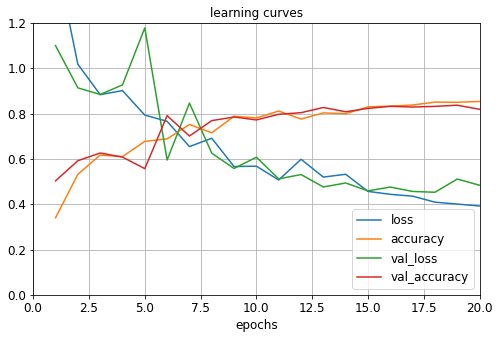

In [32]:
plot_learning_curves(logs['developed_optimized_model'])

## GridSearchCV

In [33]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn import svm
from sklearn.neural_network import MLPClassifier


# define the grid search parameters
parameter_space = {
    'hidden_layer_sizes': [(10,30,10),(20,)],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
    'batch_size' : [10, 20, 40, 60, 80, 100]}

clf = MLPClassifier(solver='lbfgs', alpha=1, tol=5e-3)



grid = GridSearchCV(estimator=clf, param_grid=parameter_space, n_jobs=-1)

In [34]:
grid.fit(X, y) 

MemoryError: Unable to allocate 2.01 GiB for an array with shape (4000, 150, 150, 3) and data type float64

In [ ]:
best_model = grid.best_params_
best_model

# References
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
https://www.kaggle.com/code/hectorlopezhernandez/colorectalhistologymodel-cnn?scriptVersionId=111780293
https://medium.com/@ashraf.dasa/tensorflow-image-classification-of-colorectal-cancer-histology-92-5-accuracy-8b8b40ac775a